# Imports
Imports necesarios para correr el notebook

In [101]:
import pandas as pd, spacy, math
import matplotlib.pyplot as plt

from datetime import datetime
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud

# Cargar modelos de Spacy
Se agregó como hiperparámetro el modelo de spacy, por lo que se pre-cargaron 4 modelos diferentes de spacy para hacer pruebas al variar el modelo

In [102]:
STOPWORDS = set(stopwords.words('english'))
ALLOWED_POSTAGS = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PART']
NLP_MODELS = {
    'en_core_web_trf': spacy.load('en_core_web_trf'),    
    'en_core_web_sm': spacy.load('en_core_web_sm'),
    'en_core_web_md': spacy.load('en_core_web_md'),
    'en_core_web_lg': spacy.load('en_core_web_lg')
}

# Clase Model
Se definió una clase model que recibe los hiperparámetros con los que se puede entrenar el modelo. Se tomó de base la clase de Modelo utilizado en la tarea anterior.

In [121]:
class Model:
    # not necesarry but just as a 'fyi'
    raw_data = [] # constructor
    stopwords = STOPWORDS # default if not given
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    debug_history = dict()
    ngram_model = None
    words = []
    
    def __init__(self, df, steps
                 , num_topics=10
                 , nlp_model = 'en_core_web_lg'
                 , stopwords=STOPWORDS
                 , ngrams=2
                 , min_count=5
                 , threshold=10
                 , allowed_postags=ALLOWED_POSTAGS
                 , debug = False
                 , random_state=100
                 , update_every=1
                 , chunksize=100
                 , passes=10
                 , alpha='auto'
                 , per_word_topics=True
        ):
        self.steps = steps
        self.stopwords = stopwords
        self.num_topics = num_topics
        self.raw_data = df
        self.ngram = {'min_count': min_count, 'threshold': threshold, 'ngrams': ngrams}
        self.lda_model_params = {'random_state': random_state, 'update_every': update_every, 'chunksize': chunksize, 'passes': passes, 'alpha': alpha, 'per_word_topics': per_word_topics}
        self.allowed_postags = allowed_postags
        self.debug = debug
        if nlp_model not in NLP_MODELS:
            nlp_model = 'en_core_web_lg'
        self.nlp = NLP_MODELS[nlp_model]
    
    def fit(self):
        
        print(f'{datetime.now()}  start')

        # split sentences into array of words
        print(f'{datetime.now()}    sentences_as_words')
        result = self.sentences2words(self.raw_data)

        if (self.debug):
            self.debug_history['sentences_as_words'] = result
            
        # iterate the pipeline
        for step in self.steps:
            print(f'{datetime.now()}    {step}')

            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
                if (self.debug):
                    self.debug_history['words_without_stopwords'] = result

            elif step == 'lemmatization':
                result = self.lemmatization(result)
                if (self.debug):
                    self.debug_history['lemmas'] = result

            elif step == 'ngram':
                # train ngram model
                ngram_model = self.train_ngrams(result, ngrams=self.ngram['ngrams'], min_count=self.ngram['min_count'], threshold=self.ngram['threshold'])

                if len(ngram_model)>0:
                    self.ngram_model = ngram_model

                    # apply ngram model
                    result = self.create_ngrams(ngram_model, result)
                    if (self.debug):
                        self.debug_history['ngrams'] = result
                else:
                    print(f'{datetime.now()} ngram not done: {self.ngram["ngram"]}')

            else:
                print(f'{datetime.now()} instruction not found: {step}')
            
        # save words in a 1d array
        words = self.array2dto1d(result)
        if (self.debug):
            self.debug_history['words'] = words
        
        # build dictionary
        dictionary = Dictionary([words])
        self.dictionary = dictionary
        
        # calculate corpus as an array of bag of words
        corpus = [dictionary.doc2bow(text) for text in result]
        if (self.debug):
            self.debug_history['corpus'] = corpus
            
        print(f'{datetime.now()}   creating model')
        
        # train LDA Model
        self.lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=self.num_topics, 
            random_state=self.lda_model_params['random_state'],
            update_every=self.lda_model_params['update_every'],
            chunksize=self.lda_model_params['chunksize'],
            passes=self.lda_model_params['passes'],
            alpha=self.lda_model_params['alpha'],
            # beta=1,
            per_word_topics=self.lda_model_params['per_word_topics']
        )
        
        print(f'{datetime.now()}   creating coherence model')
        
        # Coherence model
        self.coherence_model_lda = CoherenceModel(
            model=self.lda_model
            , texts=result
            , dictionary=dictionary
            , coherence='c_v'
        )
        
        print(f'{datetime.now()}  end')
        
    def predict_list(self, list_of_sentences, debug=False):
        results = []
        for sentence in list_of_sentences:
            results.append({'sentence': sentence, **self.predict(sentence, debug)})
        return results
    
    
    def predict(self, sentence, debug=False):
        """returns document topics"""
        sentences = [sentence]
        result = self.sentences2words(sentences)
        if debug:
            print(f'{datetime.now()} {result}')
            
        # apply pipeline to sentence
        for step in self.steps:
            if debug:
                print(f'{datetime.now()} {step}')
            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
            elif step == 'lemmatization':
                result = self.lemmatization(result)
            elif step == 'ngram':
                if (self.ngram_model != None and len(self.ngram_model)>0):                   
                    result = self.create_ngrams(self.ngram_model, result)
                else:
                    print(f'no ngram model found')
            else:
                print(f'instruction not found: {step}')
            if debug:
                print(f'{datetime.now()} {result}')
  
        words_bow = [self.dictionary.doc2bow(text) for text in result]
        return self.lda_model.get_document_topics(words_bow[0])      
    
    def sentences2words(self, sentences):
        """
        receives a list of strings (sentences) ['hello world', 'test, sentence!'] 
        and returns for each sentence a split of its words: [['hello','world'], ['test','sentence']]
        using gensim simple_preprocess function
        """
        words = []
        for sentence in sentences:
            words.append(simple_preprocess(sentence, deacc=True))
        return words
        
    def remove_stopwords(self, list_of_list_of_words):
        """
        receives a list of list of words [['abc', 'abc', ...], ...]
        """
        words = []
        for sentence_as_words in list_of_list_of_words:
            words.append([word for word in sentence_as_words if word not in self.stopwords])
        return words
            
    def lemmatization(self, list_of_list_of_words):
        """
        receives a list of list of words [['swimming','after','playing']]
        and returns the same list with each words lemma: [['swim','after','play']]
        """
        words = []        
        for sentence_as_words in list_of_list_of_words:
            doc = self.nlp(' '.join(sentence_as_words))
            words.append([token.lemma_ for token in doc if token.pos_ in self.allowed_postags ])
        return words
    
    def array2dto1d(self, array2d):
        """
        receives a list of list of words [['hello','world'],['test']] 
        and returns in a single list ['hello','world','test']
        """
        result = []
        for array1d in array2d:
            result.extend(array1d)
        return result
            
    def train_ngrams(self, list_of_list_of_words, ngrams=2, min_count=5, threshold=10):
        if ngrams < 2:
            ngrams = 2
        result = list_of_list_of_words
        ngram_models = []
        for i in range(ngrams-1):
            ngram_phraser = Phrases(result, min_count=min_count, threshold=threshold)
            ngram_model = Phraser(ngram_phraser)
            ngram_models.append(ngram_model)
            result = list(ngram_model[result])
            
        return ngram_models
    
    def create_ngrams(self, ngram_model_array, list_of_list_of_words):
        """ngram_model = []"""
        result = list_of_list_of_words
        for ngram_model in ngram_model_array:
            result = list(ngram_model[result])
        return result        

# Word Cloud
Se definió una función para graficar un word cloud de cada tópico obtenido por el modelo.

In [111]:
def plot_cloud(model, export=False):
    topics_array = model.lda_model.get_topics()
    columns = 2
    rows = math.ceil(len(topics_array)/columns)
    
    fig, ax = plt.subplots(rows, columns, figsize = (18, 25))
    ax = ax.ravel()
    
    for topic_i in range(len(topics_array)):
        topic = topics_array[topic_i]
        wordcloud_text = {model.dictionary[i] : topic[i] * 1000 for i in range(len(topic))} # i has the index of the dictionary
#         {'palabra': weight}
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width = 400
            , height = 200
            , background_color='white'
            , margin=2
        )

        wordcloud.fit_words(wordcloud_text)
     
        ax[topic_i].imshow(wordcloud)
        ax[topic_i].set_title(f'Topic {topic_i}')
        ax[topic_i].set_axis_off()
        
        if (export):
            # export as image
            wordcloud.to_file(f'images/topic_{topic_i}.png')
    plt.show()

# Carga de datos
El dataset tokens_topics se construyó con un proceso en scrapy en el que se partió de un tópico en específico, el cual fue guardado en una columna en el CSV. Cada fila corresponde a un artículo de wikipedia que surgió del tópico base

In [105]:
df = pd.read_csv('data/tokens_topics.csv')
data = df.text.values.tolist()

In [106]:
df

,topic,title,text
0,Art and culture,Visual arts,Art forms that create works that are primarily...
1,Art and culture,Visual Arts (company),Visual ArtsTypeKabushiki gaishaIndustryPC game...
2,Art and culture,The Church at Auvers,The Church at AuversArtistVincent van GoghYear...
3,Art and culture,Oil painting,Process of painting with pigments that are bou...
4,Art and culture,Painting,"Practice of applying paint, pigment, color or ..."
...,...,...,...
867,Technology and applied sciences,Tupolev,Russian Aerospace and defence Manufacturer com...
868,Technology and applied sciences,Yakovlev,This article is about the Russian aircraft man...
869,Technology and applied sciences,Irkut Corporation,Russian aircraft manufacturer. JSC Irkut Corpo...
870,Technology and applied sciences,Beriev,Russian Aircraft Company. Beriev Aircraft Comp...


Cantidad de artículos por tópico

In [107]:
df.groupby(['topic'])['topic'].count()

topic
Art and culture                     83
Geography and places               110
Health and fitness                  81
History and events                  73
Mathematics and abstractions        72
Natural sciences and nature         88
People and self                     75
Philosophy and thinking             59
Religion and spirituality           56
Social sciences and society         94
Technology and applied sciences     81
Name: topic, dtype: int64

# Ejemplo, Modelo de Prueba
Se entrena un modelo simple para hacer pruebas del flujo completo

In [108]:
model_test = Model(
    data
    , ['remove_stopwords', 'lemmatization', 'ngram']
    , num_topics = 11
    , nlp_model = 'en_core_web_lg'
    , stopwords=STOPWORDS
    , ngrams=2
    , min_count=10
    , threshold=30
    , allowed_postags=ALLOWED_POSTAGS
    , debug = False
    ## lda_model params
    , random_state=100
    , update_every=1
    , chunksize=100
    , passes=10
    , alpha='auto'
    , per_word_topics=True
)
model_test.fit()

2022-07-10 21:06:39.536551  start
2022-07-10 21:06:39.536994   sentences_as_words
2022-07-10 21:07:01.220694   remove_stopwords
2022-07-10 21:07:02.437448   lemmatization
2022-07-10 21:18:31.305038   ngram
2022-07-10 21:20:26.669106 end


Ver los **tópicos obtenidos**

In [109]:
model_test.lda_model.print_topics()

[(0,
  '0.016*"philosophy" + 0.008*"theory" + 0.006*"religion" + 0.006*"also" + 0.005*"work" + 0.005*"philosopher" + 0.005*"school" + 0.005*"see" + 0.004*"knowledge" + 0.004*"science"'),
 (1,
  '0.000*"plaster" + 0.000*"plasmodium" + 0.000*"plastically" + 0.000*"plastica" + 0.000*"plastic" + 0.000*"plasterwork" + 0.000*"plasterer" + 0.000*"plasticiser" + 0.000*"plasmasphere" + 0.000*"plasma"'),
 (2,
  '0.026*"history" + 0.009*"th_century" + 0.009*"early" + 0.007*"write" + 0.007*"century" + 0.007*"work" + 0.007*"modern" + 0.007*"culture" + 0.006*"language" + 0.006*"german"'),
 (3,
  '0.025*"retrieve" + 0.013*"archive_original" + 0.010*"space" + 0.008*"first" + 0.007*"satellite" + 0.007*"launch" + 0.007*"aircraft" + 0.006*"company" + 0.006*"mission" + 0.006*"state"'),
 (4,
  '0.019*"science" + 0.017*"history" + 0.015*"earth" + 0.013*"study" + 0.008*"natural" + 0.007*"use" + 0.006*"physics" + 0.006*"scientific" + 0.006*"chemistry" + 0.006*"system"'),
 (5,
  '0.022*"human" + 0.019*"archaeo

Ver la **coherencia del modelo**

In [112]:
# model.lda_model.alpha
model_test.coherence_model_lda.get_coherence()

0.5331752799209897

Graficar **word clouds de los tópicos** obtenidos

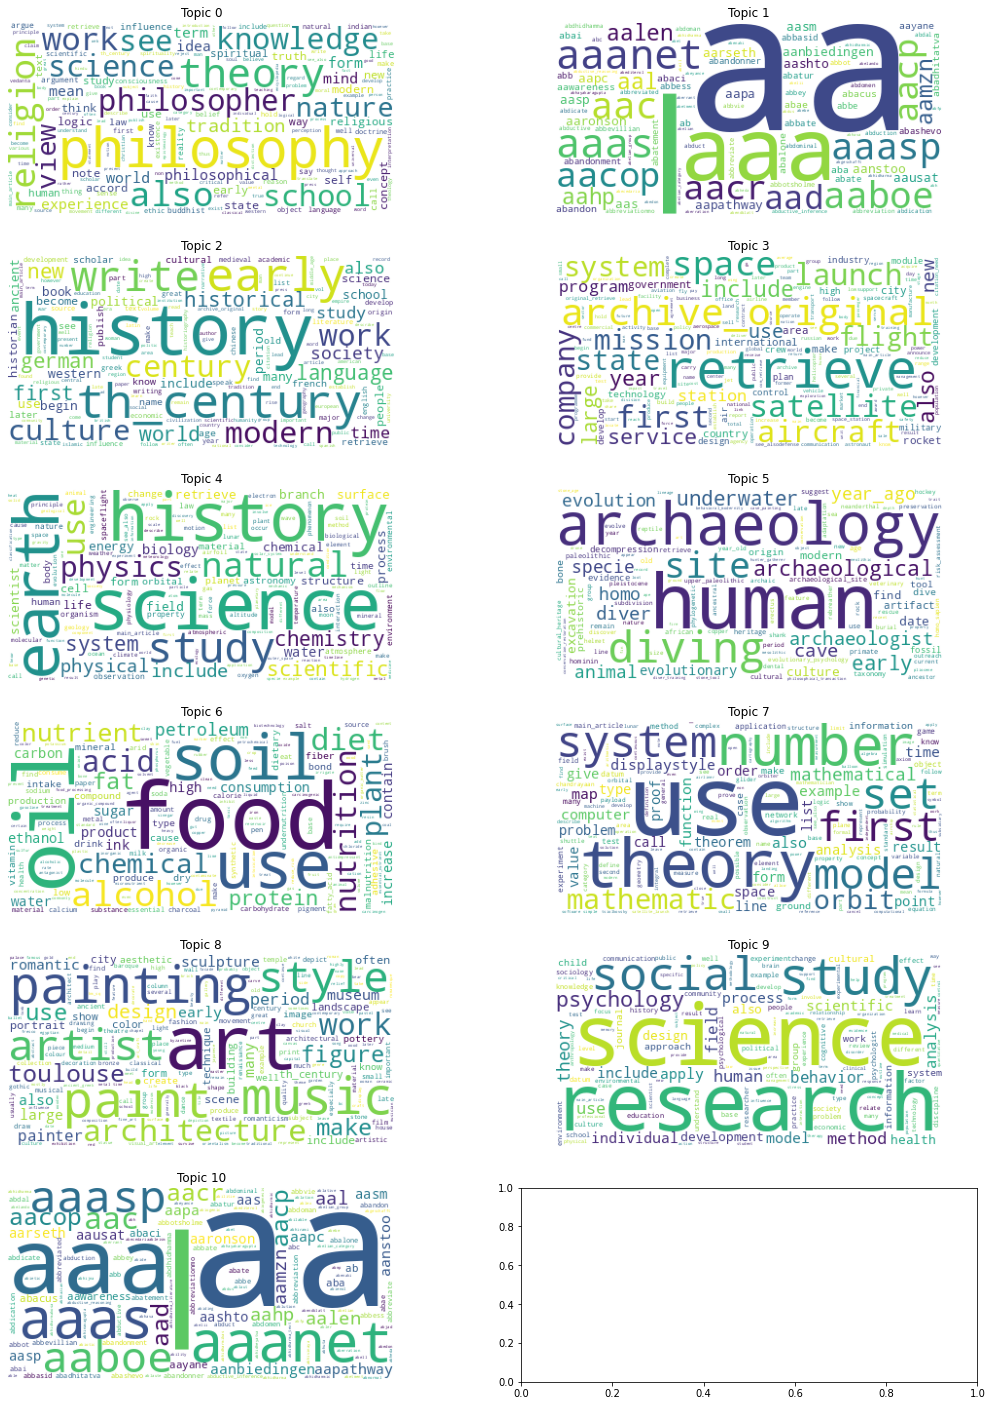

In [113]:
plot_cloud(model_test)

In [38]:
model.predict('hello stay astdast', debug=True)

2022-07-09 13:08:54.124851 [['hello', 'stay', 'astdast']]
2022-07-09 13:08:54.124935 remove_stopwords
2022-07-09 13:08:54.124966 [['hello', 'stay', 'astdast']]
2022-07-09 13:08:54.124982 lemmatization
2022-07-09 13:08:54.138254 [['stay', 'astdast']]
2022-07-09 13:08:54.138311 ngram
2022-07-09 13:08:54.138421 [['stay', 'astdast']]


[(0, 0.026924526),
 (1, 0.017215881),
 (2, 0.02955506),
 (3, 0.027740393),
 (4, 0.02706025),
 (5, 0.018617827),
 (6, 0.026982583),
 (7, 0.028071536),
 (8, 0.7683267),
 (9, 0.029505268)]

In [83]:
print(model_test.debug_history)

{}


# Definir todos los modelos a entrenar
Se creó un dataframe para incluir todos los modelos con los que se desea entrenar para hacer pruebas

In [114]:
models_to_train = []

# ###################################
# solo stopwords
# ###################################
models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'random_state': 100, 'update_every': 1, 'chunksize': 100
    ,'passes': 10, 'alpha':'auto', 'per_word_topics':True
})

# ###################################
# solo ngrams
# ###################################
models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 10, 'threshold': 30
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'random_state': 100, 'update_every': 1, 'chunksize': 100
    ,'passes': 10, 'alpha':'auto', 'per_word_topics':True
})

# ###################################
# solo lematizando
# variando el modelo de spacy
# ###################################
models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'random_state': 100, 'update_every': 1, 'chunksize': 100
    ,'passes': 10, 'alpha':'auto', 'per_word_topics':True
})



# Entrenar todos los modelos
Se entrenan todos los modelos y se obtiene la coherencia de cada uno. Los resultados se guardan en el dataframe

In [116]:
model_results = []
for model_to_train in models_to_train:
    print('*******************************************')
    print(f'Start training model {len(model_results)+1}/{len(models_to_train)}')
    print('*******************************************')
    print(model_to_train)
    print('')
    
    # build model
    model = Model(
        data
        , num_topics = 11
        , stopwords=STOPWORDS
        , debug = False
        
        , steps = model_to_train['steps']
        # NGrams params
        , ngrams = model_to_train['ngrams']
        , min_count = model_to_train['min_count']
        , threshold = model_to_train['threshold']
        
        # NLP model params (for lemmatization)
        , nlp_model = model_to_train['nlp_model']
        , allowed_postags = model_to_train['allowed_postags']
        
        # LDA model params
        , random_state = model_to_train['random_state']
        , update_every = model_to_train['update_every']
        , chunksize = model_to_train['chunksize']
        , passes = model_to_train['passes']
        , alpha = model_to_train['alpha']
        , per_word_topics = model_to_train['per_word_topics']
    )
    
    # train model
    time_start_training = datetime.now()
    model.fit()
    train_min = (datetime.now()-time_start_training).total_seconds()/60.0
    print('Training time: '+'%.2f'%train_min+' min')
    
    # calculate coherence
    print('')
    print(f'{datetime.now()} coherence metric')
    time_start_eval = datetime.now()
    coherence_value = model.coherence_model_lda.get_coherence()
    eval_sec = (datetime.now()-time_start_eval).total_seconds()
    print('Coherence: '+'%.6f'%coherence_value)
    print('Calculate Coherence time: '+'%.2f'%eval_sec+' seconds')
    
    # append results
    model_results.append({**model_to_train, 'coherence':coherence_value, 'train_min':train_min, 'model':model})
    print('')

*******************************************
Start training model 1/3
*******************************************
{'steps': ['remove_stopwords'], 'ngrams': None, 'min_count': None, 'threshold': None, 'nlp_model': None, 'allowed_postags': None, 'random_state': 100, 'update_every': 1, 'chunksize': 100, 'passes': 10, 'alpha': 'auto', 'per_word_topics': True}

2022-07-10 21:46:29.464158  start
2022-07-10 21:46:29.464227   sentences_as_words
2022-07-10 21:46:51.834766   remove_stopwords
2022-07-10 21:49:25.444080 end
Training time: 2.94 min

2022-07-10 21:49:25.686075 coherence metric
Coherence: 0.579016
Calculate Coherence time: 0.00 seconds

*******************************************
Start training model 2/3
*******************************************
{'steps': ['ngram'], 'ngrams': 2, 'min_count': 10, 'threshold': 30, 'nlp_model': None, 'allowed_postags': None, 'random_state': 100, 'update_every': 1, 'chunksize': 100, 'passes': 10, 'alpha': 'auto', 'per_word_topics': True}

2022-07-10 21:

In [117]:
df_results = pd.DataFrame(model_results)
df_results.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,random_state,update_every,chunksize,passes,alpha,per_word_topics,coherence,train_min
0,[remove_stopwords],NaN,NaN,NaN,None,None,100,1,100,10,auto,True,0.579016,2.937031
1,[ngram],2.0,10.0,30.0,None,None,100,1,100,10,auto,True,0.440202,4.243427
2,[lemmatization],NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",100,1,100,10,auto,True,0.518692,16.980865


## Buscar mejor modelo
Se ordenó el dataframe según la coherencia para buscar el mejor modelo

In [118]:
df_results = df_results.sort_values(by=['coherence'], ascending=False)
df_results.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,random_state,update_every,chunksize,passes,alpha,per_word_topics,coherence,train_min
0,[remove_stopwords],NaN,NaN,NaN,None,None,100,1,100,10,auto,True,0.579016,2.937031
2,[lemmatization],NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",100,1,100,10,auto,True,0.518692,16.980865
1,[ngram],2.0,10.0,30.0,None,None,100,1,100,10,auto,True,0.440202,4.243427


In [119]:
best_model=df_results.iloc[0]['model']

## Graficar word clouds
Se graficó el word cloud de los tópicos obtenidos por el mejor modelo

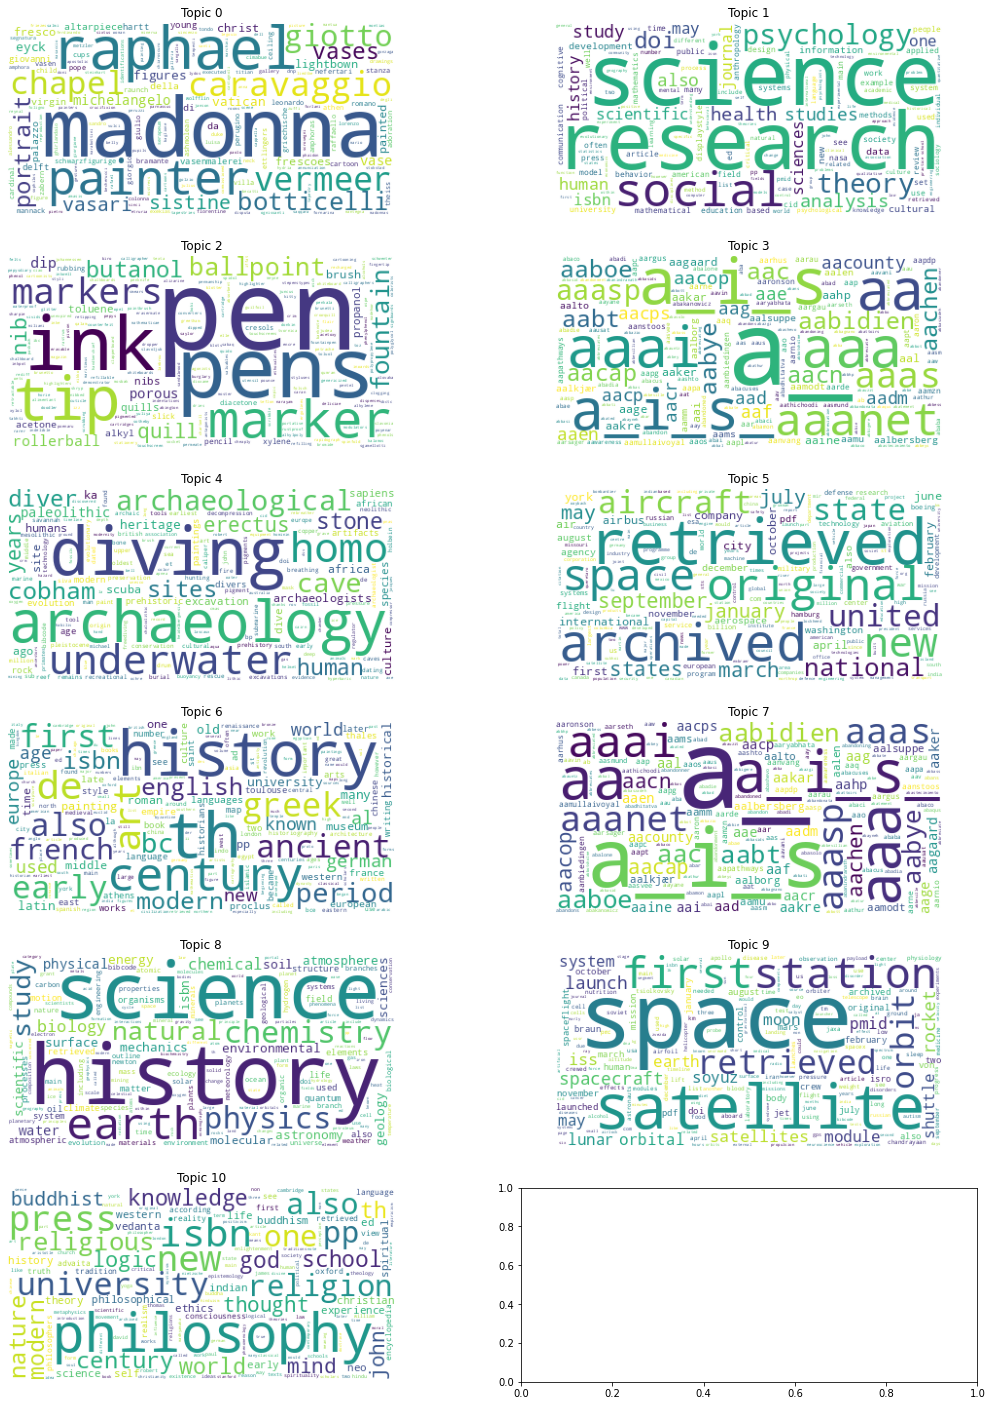

In [120]:
plot_cloud(best_model)

## Clasificación de tópicos
Revisar los tópicos obtenidos en el mejor modelo y buscar hacerles algún sentido

## Sanity check
Aplicar la función de predict a artículos con tópico conocido y verificar qué tan bien clasifica el modelo